In [120]:
import os
import numpy as np
import imageio
import cv2
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle as pkl
import pandas as pd 
import math 

from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
from statistics import mean
from  sklearn.metrics import mean_squared_error
from scipy.interpolate import interp2d

GRID_LENGTH = 4.95
BASELINE = 12 # cm
PIXEL_LENGTH = 0.0002 # cm
FOCAL_LENGTH = PIXEL_LENGTH*1000 # cm (may need to double check camera model)

# saved_indices = {}
# saved_indices['cup_all_testset'] = cup_index
# saved_indices['teabag_all_testset'] = teabag_index
# saved_indices['tap_all_testset'] = tap_index
# with open('./selected_indices.pkl', 'wb') as file:
#     pkl.dump(saved_indices, file)

with open('selected_indices.pkl', 'rb') as file:
    saved_indices = pkl.load(file)
    
teabag_index = saved_indices['teabag_all_testset']
cup_index = saved_indices['cup_all_testset']
tap_index = saved_indices['tap_all_testset']
tap_true_vect = [(1,0,0), (0,1,0),(2,2,0), (1,-2,0), (-3,2,0)]
tb_true_vect = [(1,0,0), (0,1,0),(2,2,0), (2,-3,0), (0,5,0), (-4,1,0), (6,-5,0)]
cup_true_vect = [(1,0,0), (0,1,0),(3,2,0), (-2,2,0), (4,1,0), (2,-4,0), (-2,-1, 0)]

def distanceCal(x,y,z):
    return sqrt(x**2 + y**2 + z**2)

def formHeaders(prefix, parts):
    new_headers = prefix
    for part in parts:
        for j, word in enumerate(part):
            new_headers[j] = '-'.join([new_headers[j], word])
    return new_headers

def getVectorDisplacement(coord3D, selected_indices=[]):
    # convert 3D coordinates of objects to their corresponding displacement
    # vectors from frame to frame by selected indices or all frames if empty.
    prev_coord, result_vectors = False, []
    for ind, object_coord in enumerate(coord3D):
        if len(selected_indices) > 1 and not ind in selected_indices: 
            continue
        if not prev_coord:
            prev_coord = object_coord
        else: 
            obj_vectors = []
            for m in range(len(object_coord)):
                X_delta = object_coord[m][0] - prev_coord[m][0]
                Y_delta = object_coord[m][1] - prev_coord[m][1] 
                Z_delta = object_coord[m][2] - prev_coord[m][2]
                obj_vectors.append([X_delta, Y_delta, Z_delta])
            result_vectors.append(obj_vectors)
            prev_coord = object_coord
    return result_vectors

def pixelInterpolation(x, y, f):
    x, y = min(x + .0001, len(f[0])-1), min(y + .0001, len(f)-1)
    x1, x2 = math.floor(x), math.ceil(x)
    y1, y2 = math.floor(y), math.ceil(y)
    fxy2 = (x2 - x)*f[y2, x1] + (x - x1)*f[y2, x2] 
    fxy1 = (x2 - x)*f[y1, x1] + (x - x1)*f[y1, x2] 
    return (y - y1)*fxy2 + (y2 - y)*fxy1

def pixelTo3DCameraCoord(left_img, disp_map, coords):
    result_coords = []
    img_dims, disp_dims = left_img.shape, disp_map.shape
    fixed_ratios = [img_dims[dim]/disp_dims[dim] for dim in range(2)]
    for pix in coords:
        # Different ordering of dims between coordinate and images fixed here.
        if len(pix) == 0: continue
        x_l, y_l = (int(i) for dim, i in enumerate(pix[0]))
        d_x, d_y = pix[0][0]/fixed_ratios[1], pix[0][1]/fixed_ratios[0]
        d = pixelInterpolation(d_y, d_x, disp_map)*fixed_ratios[1]
        print(d, disp_map[int(d_y), int(d_x)]*fixed_ratios[1])
        x_r = int(x_l - d)
        
        # Z is the depth from camera center in cm and X, Y for the other 2 axis.
        Z = BASELINE*FOCAL_LENGTH/(d*PIXEL_LENGTH)
        X, Y = (x_l - img_dims[1]/2)*PIXEL_LENGTH*Z/FOCAL_LENGTH, (y_l - img_dims[0]/2)*PIXEL_LENGTH*Z/FOCAL_LENGTH
        result_coords.append({'left_x':x_l, 'left_y':y_l, 'right_x':x_r, 'X':X, 'Y':Y, 'Z':Z})
    return result_coords

def LEAStereoCoordinate(l_img_path, disp_path, l_datafile):
    with open(l_datafile, 'rb') as l_dataf:
        l_data = pkl.load(l_dataf)
    left_cam_files = os.listdir(l_img_path)
    disp_files = os.listdir(disp_path)
    coordinate3D = {}
    for framename in l_data.keys():
        img_file = '{}.jpg'.format(framename)
        disp_file = "{}_disp.npy".format(img_file.split('.')[0])
        if img_file in left_cam_files:
            im_disp = np.load(disp_path + disp_file)
            im_l = imageio.imread(l_img_path + img_file)
            pixel_coordinates = l_data[framename]['coordinates'][0]
            coordinate3D[framename] = pixelTo3DCameraCoord(im_l, im_disp, pixel_coordinates)
    return coordinate3D

def getMeasurements(model_pos): 
    model_dist = []
    model_vect = getVectorDisplacement(model_pos)
    for vector_set in model_vect:
        dist_set = []
        for vec in vector_set:
            dist_set.append(distanceCal(*vec))
        model_dist.append(mean(dist_set))
    return model_vect, model_dist

def findLosses(true_values, raw_values, scales):
    losses = []
    for scaling in scales:
        new_raw_values = [scaling*i for i in raw_values]
        losses.append(mean_squared_error(true_values, new_raw_values))
    return losses

In [121]:
# Getting the coordinate from the dlc folder for now
object_set = 'teabag_all_testset'
l_tb_img_dir = './dataset/{}/left/'.format(object_set)
r_tb_img_dir = './dataset/{}/right/'.format(object_set)
tb_disp_path = './dataset/{}/disparity/'.format(object_set)

l_tb_datafile = '../camera-main/videos/{}/1639767318-leftDLC_resnet50_make_tea_multiNov11shuffle1_100000_full.pickle'.format(object_set)
r_tb_datafile = '../camera-main/videos/{}/1639767318-rightDLC_resnet50_make_tea_multiNov11shuffle1_100000_full.pickle'.format(object_set)

with open(r_tb_datafile, 'rb') as r_dataf:
    r_tb_data = pkl.load(r_dataf)
        
tb_coordinate3D = LEAStereoCoordinate(l_tb_img_dir, tb_disp_path, l_tb_datafile)

tb_true_dist = []
tb_model_pos = []
for vec in tb_true_vect:
    vec = [GRID_LENGTH*i for i in vec]
    tb_true_dist.append(distanceCal(*vec))
        
for i in tb_coordinate3D.keys():
    holder = []
    for pos in tb_coordinate3D[i][:3]:
        holder.append([pos['X'], pos['Y'], pos['Z']])
    tb_model_pos.append(holder)

tb_model_vect, tb_model_dist = getMeasurements(tb_model_pos)
# print([tb_true_dist[i] - tb_model_dist[i] for i in range(7)])
print('LEAstereo MSE:', mean_squared_error(tb_true_dist, tb_model_dist))

188.79937215775362 158.25192260742188
190.73149649161462 154.6392822265625
194.63439298957962 150.29844665527344
0.0 213.344482421875
0.0 201.8844451904297
0.0 193.17697143554688
156.32751698011393 193.63735961914062
177.71020086577732 189.69094848632812
180.4813412545641 176.85888671875
159.2402480370824 241.36407470703125
160.5126984884875 230.71922302246094
157.82112163105057 223.64341735839844
196.25998896436 156.8824005126953
196.0832229974646 154.4349365234375
197.86802200453263 152.16989135742188
0.0 212.8761749267578
0.0 200.30557250976562
0.0 193.62857055664062
157.2233197804314 198.4017791748047
177.12565109491086 189.03343200683594
180.8361751378362 176.57473754882812
158.73492913774862 240.10562133789062
160.35983720836506 230.51638793945312
194.98607879864252 130.36329650878906
197.15056518068627 162.79949951171875
196.49022683427884 160.3233184814453
194.89589801239043 155.08828735351562
0.0 211.67376708984375
0.0 199.50035095214844
0.0 192.3983154296875
156.4856364392679

/tmp/ipykernel_1106427/961198543.py:92: RuntimeWarning: divide by zero encountered in double_scalars
  Z = BASELINE*FOCAL_LENGTH/(d*PIXEL_LENGTH)


0.0 148.9763946533203
0.0 151.05984497070312
0.0 151.06488037109375
0.0 212.27256774902344
0.0 201.62246704101562
0.0 193.1158447265625
155.44536217785716 201.2799835205078
177.10431284391834 189.73321533203125
181.01212863968672 177.35321044921875
159.17417489599728 240.97256469726562
160.3310452252988 231.43130493164062
0.0 137.7734832763672
0.0 187.86830139160156
0.0 178.93179321289062
0.0 174.9581298828125
0.0 211.669921875
0.0 200.72598266601562
0.0 191.75759887695312
155.18728549143918 198.6127471923828
177.26216834909818 190.270751953125
181.01098698171802 177.24159240722656
160.37874953613368 240.7177276611328
160.7796300279308 231.29769897460938
255.70660380284232 83.2682113647461
193.26539252585852 191.18417358398438
194.82660483460285 186.14747619628906
196.10034776939193 179.10336303710938
0.0 212.8878173828125
0.0 198.23541259765625
0.0 191.1328125
156.6608871500876 196.9215087890625
177.22511075488103 188.24911499023438
181.03921071869587 177.44468688964844
158.0521119645

/tmp/ipykernel_1106427/961198543.py:62: RuntimeWarning: invalid value encountered in double_scalars
  X_delta = object_coord[m][0] - prev_coord[m][0]
/tmp/ipykernel_1106427/961198543.py:64: RuntimeWarning: invalid value encountered in double_scalars
  Z_delta = object_coord[m][2] - prev_coord[m][2]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [72]:
tb_model_pos

[[[-5.156406635028261, -9.25120013931541, 75.8295093386509],
  [-4.805492604612714, -12.323763292474538, 77.50794523568892],
  [-4.38769087469137, -15.157477567115642, 79.77619772166128]],
 [[-0.15299887942844814, -9.179932765706887, 76.49943971422407],
  [0.07776251893389147, -12.208715472620963, 77.76251893389147],
  [0.4727415233833761, -14.812567732679117, 78.79025389722935]],
 [[-0.4415499410897965, -5.4457826067741575, 73.59165684829942],
  [-0.29918212327177135, -8.302303920791655, 74.79553081794283],
  [0.0, -11.130864264160289, 77.29766850111311]],
 [[8.03193249455473, 1.9058822868434957, 68.06722453012485],
  [8.423193406047664, -1.0617470679892012, 70.78313786594676],
  [9.149470369163202, -3.5581273657856896, 72.61484419970796]],
 [[20.224818159590356, -10.112409079795178, 80.25721491900936],
  [20.244237151358007, -12.711497746201537, 78.46603547037988],
  [19.848389147908758, -14.925363493112492, 78.14326436184551]],
 [[17.247684316171018, 9.645927154599349, 63.8803122821

Min MSE: 1.1490402371220543


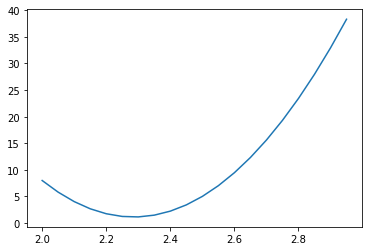

In [3]:
tb_dlc_pos = []
tb3d_path = '../camera-main/videos/{}/1639767318_make_tea_3D.csv'.format(object_set)
tb3d_csv = pd.read_csv(tb3d_path)
part1 = tb3d_csv.iloc[0].tolist()
part2 = tb3d_csv.iloc[1].tolist()
part3 = tb3d_csv.iloc[2].tolist()

new_headers = formHeaders(part1, [part2, part3])
new_tb3d_csv = tb3d_csv[3:].copy()
new_tb3d_csv.columns = new_headers

new_tb3d_csv.reset_index(inplace=True)
new_tb3d_csv = new_tb3d_csv.loc[:,['ind1-head-x', 'ind1-head-y', 'ind1-head-z',
                                    'ind1-middle-x', 'ind1-middle-y', 'ind1-middle-z',
                                    'ind1-tail-x', 'ind1-tail-y', 'ind1-tail-z']]
for i in teabag_index:
    row = [float(i) for i in new_tb3d_csv.iloc[i].tolist()]
    tb_dlc_pos.append([row[:3], row[3:6], row[6:9]])
    
tb_dlc_vect, tb_dlc_dist = getMeasurements(tb_dlc_pos)
scales = np.arange(2, 3, 0.05)
loss = findLosses(tb_true_dist, tb_dlc_dist, scales)

plt.plot(scales, loss)
print('Min MSE:', min(loss))

In [13]:
with open('../camera-main/videos/teabag_all_testset/1639767318_make_tea_3D_meta.pickle', 'rb') as file:
    meta = pkl.load(file)

In [4]:
with open('../dlc/make_tea_3d-Luke-2021-11-22-3d/camera_matrix/stereo_params.pickle', 'rb') as file:
    params = pkl.load(file)

In [5]:
tb_model_vect

[[[5.0033546280261065, 0.07222258108517288, 0.6619528681696352],
  [4.888899297204138, 0.1390792990507297, 0.10267894008008227],
  [4.864418310202261, 0.34428278844932336, -0.9819175500874877]],
 [[-0.2892809708829545, 3.724287636865933, -2.780115186796891],
  [-0.37709762565623267, 3.8911009051444942, -2.8538751631065793],
  [-0.4731553617981098, 3.683494032774721, -1.4839447656614482]],
 [[8.482362941928294, 7.362382832747984, -5.5738499747856025],
  [8.72568176715273, 7.246074273540899, -4.039617604858577],
  [9.165049247704331, 7.577854818347702, -4.636796107798659]],
 [[12.258416669016707, -12.05707951403193, 12.413223506125433],
  [12.068901750087162, -11.806934872008048, 8.629582687804657],
  [11.011711840064912, -11.608103030912591, 6.6975811817905395]],
 [[-3.0523939233366875, 19.79431337395323, -16.675140935389884],
  [-2.6559887710394463, 19.977925893457517, -12.374054483052703],
  [-2.138159497126395, 19.424734851821146, -10.84822852699061]],
 [[-20.070625463845943, 3.84978

In [6]:
tb_dlc_vect

[[[2.4840036325131862, 0.05866214088426805, -1.12642651035857],
  [2.3436116041340753, 0.12604997843407084, -0.5308736363505133],
  [2.1631952715838363, 0.07886247725856377, -0.1716951663099735]],
 [[0.22635765248229234, 1.4918531374071755, -2.0021567406373677],
  [0.2479103820127655, 1.582373317029199, -2.389595468393729],
  [-0.12563505856048707, 1.523236132746537, -0.5770605192819573]],
 [[4.212118879829393, 3.004155567058162, -2.4676908152567663],
  [4.4403841551635175, 2.9646925702495355, -3.365882118092621],
  [4.952198912958039, 2.9806666031614304, -6.0068581792501945]],
 [[3.819124187605567, -4.521655829943308, 5.815649760161861],
  [4.185655692645276, -4.544897923906685, 3.3897603628453084],
  [3.7076049410360836, -4.440816476923975, 5.109648356819363]],
 [[0.8075233622536593, 7.444977000940299, -10.470329235046883],
  [0.3996365223180074, 7.722613296503619, -7.392773602174735],
  [0.4913183412928972, 7.495406326984879, -7.8903244421296606]],
 [[-8.981972874412905, 2.169480212

In [7]:
params

{'left-right': {'cameraMatrix1': array([[1.72072669e+03, 0.00000000e+00, 9.65272858e+02],
         [0.00000000e+00, 1.70393690e+03, 4.32918506e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'cameraMatrix2': array([[1.77064495e+03, 0.00000000e+00, 9.22571983e+02],
         [0.00000000e+00, 1.76168801e+03, 3.89575908e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'distCoeffs1': array([[ 0.08817721, -0.13958785, -0.01311371, -0.01046414,  0.05741947]]),
  'distCoeffs2': array([[ 0.12593028, -0.31870511, -0.02535857, -0.01469956,  0.22729461]]),
  'R': array([[ 0.9997794 ,  0.00370644,  0.02067378],
         [-0.00418193,  0.99972663,  0.02300393],
         [-0.02058287, -0.02308531,  0.99952159]]),
  'T': array([[-5.01707006],
         [ 0.10323352],
         [ 1.02227135]]),
  'E': array([[ 2.15022795e-03, -1.02437507e+00,  7.96678693e-02],
         [ 9.18780156e-01, -1.12031636e-01,  5.03580407e+00],
         [-8.22296952e-02, -5.01608117e+00,

In [50]:
outputs_l = []
for i in tb_dlc_pos:
#     output = np.transpose(np.dot(params['left-right']['R'], np.transpose(i)))
#     output = [[row[j] + params['left-right']['T'][j][0] for j in range(3)] for row in output]
#     print(output)
    output = np.transpose(np.dot(params['left-right']['cameraMatrix1'], np.transpose(i)))
    outputs_l.append((output[1]/output[1,2])[:2])

outputs_r = []
shifted = params['left-right']['cameraMatrix2'].copy()
shifted[0,2] = params['left-right']['cameraMatrix1'][0,2]
shifted[1,2] = params['left-right']['cameraMatrix1'][1,2]
for i in tb_dlc_pos:
    output = np.transpose(np.dot(shifted, np.transpose(i)))
    outputs_r.append((output[1]/output[1,2])[:2])

In [51]:
splits_l = list(zip(*outputs_l))
splits_r = list(zip(*outputs_r))

In [52]:
shifted

array([[1.77064495e+03, 0.00000000e+00, 9.65272858e+02],
       [0.00000000e+00, 1.76168801e+03, 4.32918506e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [53]:
splits_l

[(582.0595992201376,
  647.6354527588304,
  641.6995767736003,
  766.1616667326682,
  906.7553234395575,
  911.9995386457947,
  605.5072932985299,
  1033.2346604622599),
 (401.32020795389633,
  404.711042558707,
  451.6507550169306,
  548.8160800231683,
  403.5859659763215,
  669.6843690304729,
  735.8518299413032,
  450.22586426107665)]

In [54]:
splits_r 

[(570.9425855431004,
  638.4207940846904,
  632.3127183831363,
  760.385452607246,
  905.0577302054996,
  910.4540800542234,
  595.0704970449704,
  1035.2062318149246),
 (400.2492547801771,
  403.75501409006324,
  452.2856424257334,
  552.7441673727942,
  402.5918055698255,
  677.7090149227756,
  746.1190729570341,
  450.8124582055952)]

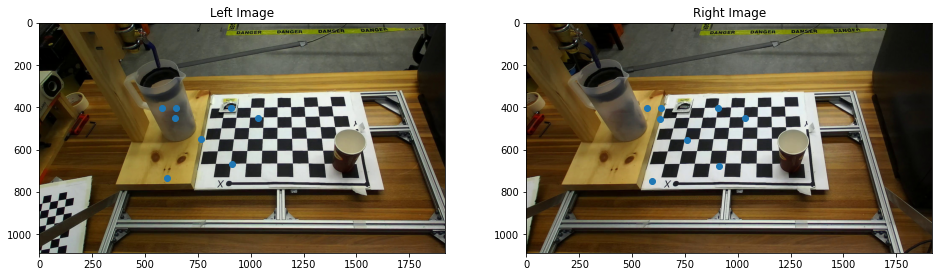

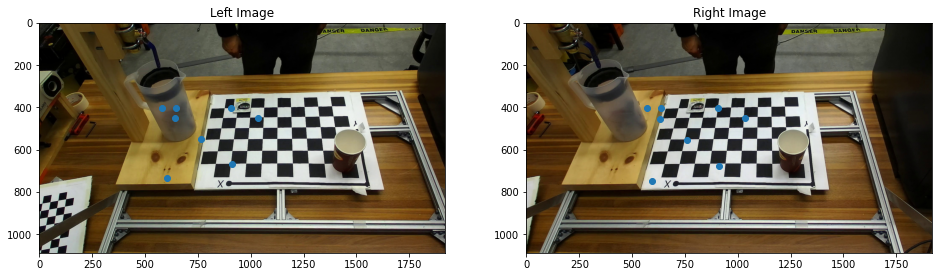

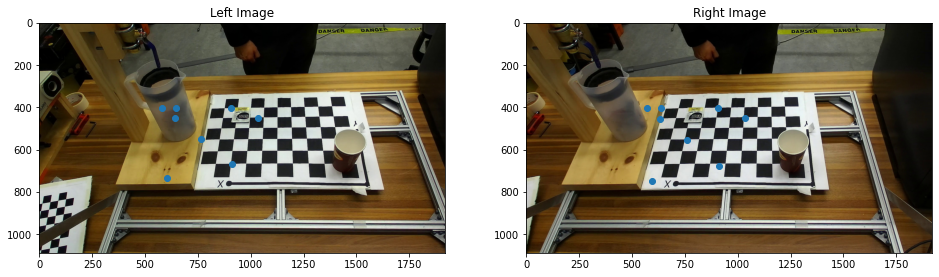

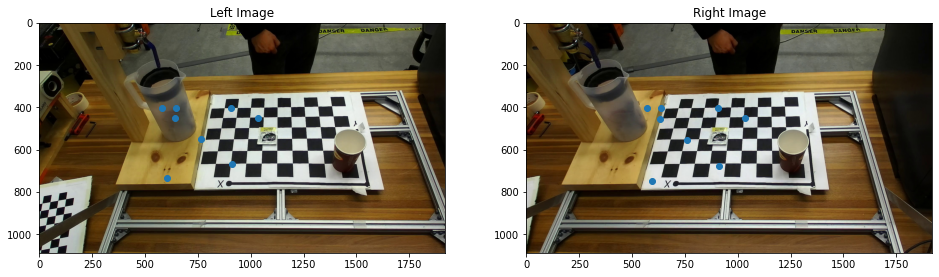

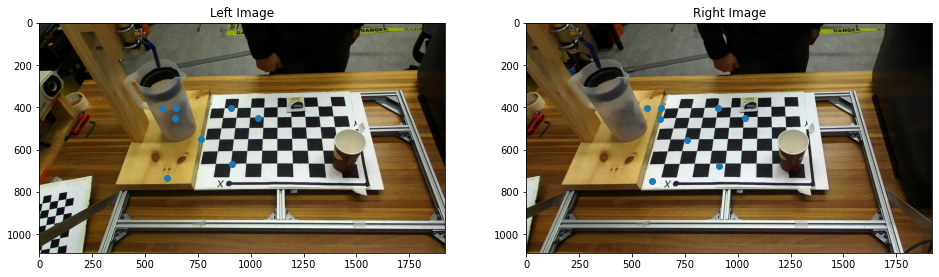

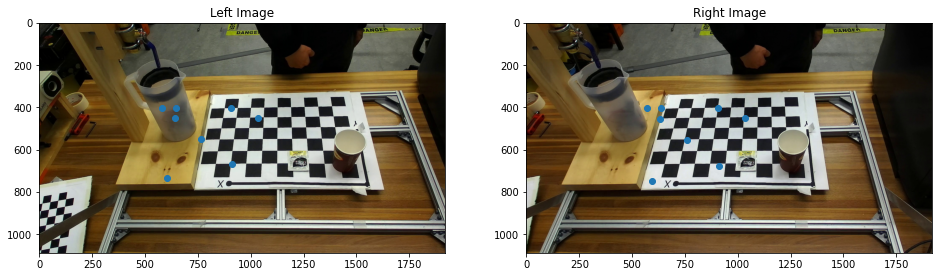

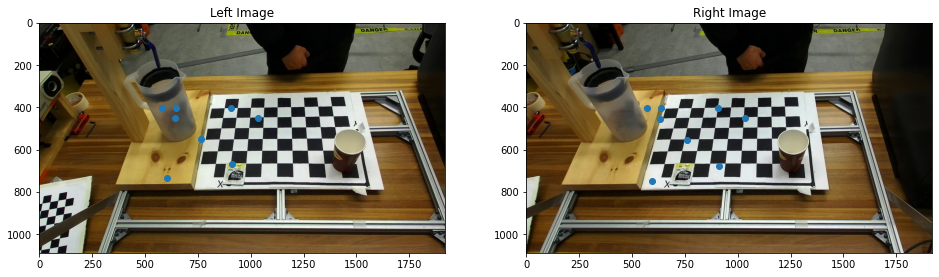

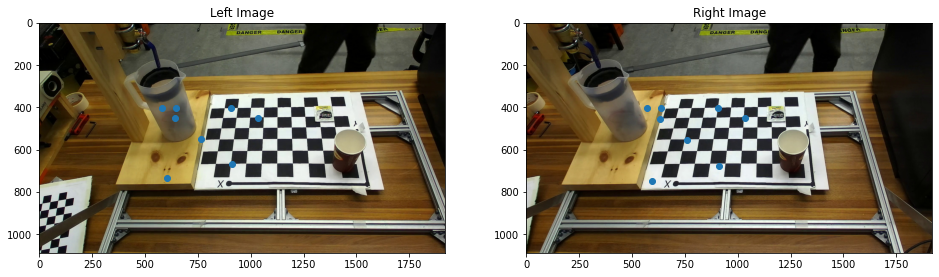

In [55]:
count = 1
for ind, key in enumerate(tb_coordinate3D.keys()):
    lx, ly, rx = [], [], [] 
    dlc_ry, dlc_rx = [], [] 
    right_coord = r_tb_data[key]['coordinates'][0]
    for pix in right_coord[:3]:
        if len(pix) == 0: continue
        x_l, y_l = (int(i) for dim, i in enumerate(pix[0]))
        dlc_ry.append(y_l)
        dlc_rx.append(x_l)
    for coor in tb_coordinate3D[key][:3]:
        lx.append(coor['left_x'])
        ly.append(coor['left_y'])
        rx.append(coor['right_x'])
    img_file = '{}.jpg'.format(key)
    img_left = imageio.imread(l_tb_img_dir + img_file)
    img_right = imageio.imread(r_tb_img_dir + img_file)

    disp_path = "{}_disp.npy".format(tb_disp_path + img_file.split('.')[0])
    img_disparity = np.load(disp_path)
    fig = plt.figure(figsize=(16, 40))

    fig.add_subplot(8, 2, count)
    plt.title('Left Image')
    plt.imshow(img_left)
    plt.scatter(splits_l[0], splits_l[1])
    
#     plt.scatter(lx, ly)
    
    fig.add_subplot(8, 2, count+1)
    plt.title('Right Image')
    plt.imshow(img_right)
    plt.scatter(splits_r[0], splits_r[1])
#     plt.scatter(rx, ly)
#     plt.scatter(dlc_rx, dlc_ry)
    count += 2
#     fig.add_subplot(3, 1, 3)
#     plt.title('Disparity (Left-Camerea View)')
#     plt.imshow(img_disparity)

In [39]:
# Getting the coordinate from the dlc folder for now
tap_object_set = 'tap_all_testset'
l_tap_img_dir = './dataset/{}/left/'.format(tap_object_set)
r_tap_img_dir = './dataset/{}/right/'.format(tap_object_set)
tap_disp_path = './dataset/{}/disparity/'.format(tap_object_set)

l_tap_datafile = '../camera-main/videos/{}/1639767563-leftDLC_resnet50_make_tea_multiNov11shuffle1_100000_full.pickle'.format(tap_object_set)
r_tap_datafile = '../camera-main/videos/{}/1639767563-rightDLC_resnet50_make_tea_multiNov11shuffle1_100000_full.pickle'.format(tap_object_set)

tap_true_dist = []
tap_model_pos = []
with open(r_tap_datafile, 'rb') as r_dataf:
    r_tap_data = pkl.load(r_dataf)
for vec in tap_true_vect:
    vec = [GRID_LENGTH*i for i in vec]
    tap_true_dist.append(distanceCal(*vec))
    
tap_coordinate3D = LEAStereoCoordinate(l_tap_img_dir, tap_disp_path, l_tap_datafile)

for i in tap_coordinate3D.keys():
    holder = []
    for pos in tap_coordinate3D[i][-3:-1]:
        holder.append([pos['X'], pos['Y'], pos['Z']])
    tap_model_pos.append(holder)
    
tap_model_vect, tap_model_dist = getMeasurements(tap_model_pos)
print([tap_true_dist[i] - tap_model_dist[i] for i in range(len(tap_true_dist))])
print('LEAstereo MSE:', mean_squared_error(tap_true_dist, tap_model_dist))

[-0.0657885897045265, -0.1699670067311212, 2.00699132961946, -0.1511542791641176, 0.24367956213628972]
LEAstereo MSE: 0.8286916928385386


In [ ]:
tap_dlc_pos = []
tap3d_path = '../camera-main/videos/{}/1639767563_make_tea_3D.csv'.format(tap_object_set)
tap3d_csv = pd.read_csv(tap3d_path)
part1 = tap3d_csv.iloc[0].tolist()
part2 = tap3d_csv.iloc[1].tolist()
part3 = tap3d_csv.iloc[2].tolist()

new_headers = formHeaders(part1, [part2, part3])
new_tap3d_csv = tap3d_csv[3:].copy()
new_tap3d_csv.columns = new_headers
new_tap3d_csv.reset_index(inplace=True)
new_tap3d_csv = new_tap3d_csv.loc[:,['single-tap_h-x', 'single-tap_h-y', 'single-tap_h-z',
                                    'single-tap_m-x', 'single-tap_m-y', 'single-tap_m-z']]


# new_tap3d_csv = new_tap3d_csv.drop(new_tap3d_csv.columns[[0]], axis=1) 
for i in tap_index:
    row = [float(i) for i in new_tap3d_csv.iloc[i].tolist()]
    tap_dlc_pos.append([row[:3], row[3:6]])
    
tap_dlc_vect, tap_dlc_dist = getMeasurements(tap_dlc_pos)
scales = np.arange(2, 3, 0.05)
loss = findLosses(tap_true_dist, tap_dlc_dist, scales)

plt.plot(scales, loss)
print('Min MSE:', min(loss))

In [ ]:
count = 1
for ind, key in enumerate(tap_coordinate3D.keys()):
    lx, ly, rx = [], [], [] 
    dlc_ry, dlc_rx = [], [] 
    right_coord = r_tap_data[key]['coordinates'][0]
#     for pix in right_coord:
#         if len(pix) == 0: continue
#         x_l, y_l = (int(i) for dim, i in enumerate(pix[0]))
#         dlc_ry.append(y_l)
#         dlc_rx.append(x_l)
    for coor in tap_coordinate3D[key][-3:]:
        lx.append(coor['left_x'])
        ly.append(coor['left_y'])
        rx.append(coor['right_x'])
    img_file = '{}.jpg'.format(key)
    img_left = imageio.imread(l_tap_img_dir + img_file)
    img_right = imageio.imread(r_tap_img_dir + img_file)

    disp_path = "{}_disp.npy".format(tap_disp_path + img_file.split('.')[0])
    img_disparity = np.load(disp_path)
    fig = plt.figure(figsize=(16, 40))

    fig.add_subplot(8, 2, count)
    plt.title('Left Image')
    plt.imshow(img_left)
    plt.scatter(lx, ly)
    fig.add_subplot(8, 2, count+1)
    plt.title('Right Image')
    plt.imshow(img_right)
    plt.scatter(rx, ly)
#     plt.scatter(dlc_rx, dlc_ry)
    count += 2
#     fig.add_subplot(3, 1, 3)
#     plt.title('Disparity (Left-Camerea View)')
#     plt.imshow(img_disparity)

In [ ]:
# Getting the coordinate from the dlc folder for now
cup_object_set = 'cup_all_testset'
l_cup_img_dir = './dataset/{}/left/'.format(cup_object_set)
r_cup_img_dir = './dataset/{}/right/'.format(cup_object_set)
cup_disp_path = './dataset/{}/disparity/'.format(cup_object_set)

l_cup_datafile = '../camera-main/videos/{}/1639767445-leftDLC_resnet50_make_tea_multiNov11shuffle1_100000_full.pickle'.format(cup_object_set)
r_cup_datafile = '../camera-main/videos/{}/1639767445-rightDLC_resnet50_make_tea_multiNov11shuffle1_100000_full.pickle'.format(cup_object_set)

cup_true_dist = []
cup_model_pos = []
with open(r_cup_datafile, 'rb') as r_dataf:
    r_cup_data = pkl.load(r_dataf)
for vec in cup_true_vect:
    vec = [GRID_LENGTH*i for i in vec]
    cup_true_dist.append(distanceCal(*vec))
    
cup_coordinate3D = LEAStereoCoordinate(l_cup_img_dir, cup_disp_path, l_cup_datafile)

for i in cup_coordinate3D.keys():
    holder = []
    for pos in cup_coordinate3D[i][3:6]:
        holder.append([pos['X'], pos['Y'], pos['Z']])
    cup_model_pos.append(holder)
    
cup_model_vect, cup_model_dist = getMeasurements(cup_model_pos)
# print([cup_true_dist[i] - cup_model_dist[i] for i in range(len(cup_true_dist))])
print('Cup LEAstereo MSE:', mean_squared_error(cup_true_dist, cup_model_dist))

In [ ]:
cup_dlc_pos = []
cup3d_path = '../camera-main/videos/{}/1639767445_make_tea_3D.csv'.format(cup_object_set)
cup3d_csv = pd.read_csv(cup3d_path)
part1 = cup3d_csv.iloc[0].tolist()
part2 = cup3d_csv.iloc[1].tolist()
part3 = cup3d_csv.iloc[2].tolist()

new_headers = formHeaders(part1, [part2, part3])
new_cup3d_csv = cup3d_csv[3:].copy()
new_cup3d_csv.columns = new_headers
new_cup3d_csv.reset_index(inplace=True)
new_cup3d_csv = new_cup3d_csv.loc[:,['single-cup_h-x', 'single-cup_h-y', 'single-cup_h-z',
                                    'single-cup_m-x', 'single-cup_m-y', 'single-cup_m-z',
                                    'single-cup_t-x', 'single-cup_t-y', 'single-cup_t-z']]


# new_tap3d_csv = new_tap3d_csv.drop(new_tap3d_csv.columns[[0]], axis=1) 
for i in cup_index:
    row = [float(i) for i in new_cup3d_csv.iloc[i].tolist()]
    cup_dlc_pos.append([row[:3], row[3:6], row[6:9]])
    
cup_dlc_vect, cup_dlc_dist = getMeasurements(cup_dlc_pos)
scales = np.arange(2, 3, 0.05)
loss = findLosses(cup_true_dist, cup_dlc_dist, scales)

plt.plot(scales, loss)
print('Cup Min MSE:', min(loss))

In [ ]:
# combined leastereo distances
combine_true_dist = tb_true_dist + tap_true_dist + cup_true_dist
combine_model_dist = tb_model_dist + tap_model_dist + cup_model_dist
combine_dlc_dist = tb_dlc_dist + tap_dlc_dist + cup_dlc_dist

scales = np.arange(2, 3, 0.05)
combine_model_mse = mean_squared_error(combine_true_dist, combine_model_dist)
combine_dlc_mse = findLosses(combine_true_dist, combine_dlc_dist, scales)

plt.plot(scales, combine_dlc_mse)
print('Combine Min LEAstereo MSE:', combine_model_mse)
print('Combine Min DLC MSE:', min(combine_dlc_mse))

In [ ]:

# count=0
# extra_path = '../camera-main/videos/tap_all_testset/1639767563-left.mp4'
# vidcap = cv2.VideoCapture(extra_path)
# success, first_frame = vidcap.read()
# while success:
# #     cv2.imwrite(os.path.join(l_img_dir, "frame{}.jpg".format(str(count).zfill(2))), image)     # save frame as JPEG file      
#     success, image = vidcap.read()
#     print('Read a new frame: ', success, count)
#     cv2.imshow("Input", image)
#     cv2.waitKey(0)
#     count += 1

In [ ]:
# # Select the frame in the dataset folder that will be shown below
# shown_frame = 'frame002.jpg'

# lx, ly, rx = [], [], []
# for coor in cam_coordinates[shown_frame]:
#     lx.append(coor['left_x'])
#     ly.append(coor['left_y'])
#     rx.append(coor['right_x'])
# img_left = imageio.imread(l_img_dir + shown_frame)
# img_right = imageio.imread(r_img_dir + shown_frame)
# disp_path = "{}_disp.npy".format(disp_dir + shown_frame.split('.')[0])
# img_disparity = np.load(disp_path)
# fig = plt.figure(figsize=(16, 20))
# fig.add_subplot(3, 1, 1)
# plt.title('Right Image')
# plt.imshow(img_right)
# plt.scatter(rx, ly)
# fig.add_subplot(3, 1, 2)
# plt.title('Left Image')
# plt.imshow(img_left)
# plt.scatter(lx, ly)
# fig.add_subplot(3, 1, 3)
# plt.title('Disparity (Left-Camerea View)')
# plt.imshow(img_disparity)

In [ ]:
tb_true_pos

In [ ]:
x, y, z = [], [], []
tb_true_pos = []

cur_set = tb_model_pos[0].copy()
tb_true_pos.append(cur_set.copy())
for delta in tb_true_vect:
    for i in range(len(delta)):
        cur_set[i] = [cur_set[i][j] + delta[j]*GRID_LENGTH for j in range(3)]
    tb_true_pos.append(cur_set.copy())
    
for obj_set in tb_true_pos:
    for coor in obj_set:
        x.append(coor[0])
        y.append(coor[1])
        z.append(coor[2])
    
fig = plt.figure()
ax = Axes3D(fig)

# Z-axis increasing the further objects are and X-axis increasing to the right 
# is the original camera view in the left camera coordinate system.
plot_geeks = ax.scatter(x, y, z)
ax.set_title('3D Coordinate Plot')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.view_init(270, 270)
plt.show()

In [ ]:
help(ax.view_init)

In [ ]:
# %matplotlib widget
x, y, z = [], [], []
for obj_set in tb_model_pos:
    for coor in obj_set:
        x.append(coor[0])
        y.append(coor[1])
        z.append(coor[2])
    
fig = plt.figure()
ax = Axes3D(fig)

# Z-axis increasing the further objects are and X-axis increasing to the right 
# is the original camera view in the left camera coordinate system.
plot_geeks = ax.scatter(x, y, z)
ax.set_title('3D Coordinate Plot')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.view_init(270, 270)
plt.show()


In [ ]:
# %matplotlib widget
x, y, z = [], [], []
for obj_set in tb_dlc_pos:
    for coor in obj_set:
        x.append(coor[0])
        y.append(coor[1])
        z.append(coor[2])
    
fig = plt.figure()
ax = Axes3D(fig)

# Z-axis increasing the further objects are and X-axis increasing to the right 
# is the original camera view in the left camera coordinate system.
plot_geeks = ax.scatter(x, y, z)
ax.set_title('3D Coordinate Plot')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.view_init(270, 270)
plt.show()
